# Short Put
[Projection option](https://www.projectoption.com/selling-put-options/)
[Tastytrade Short Put check list](https://www.tastytrade.com/tt/shows/mike-and-his-whiteboard/episodes/trade-checklist-short-put-04-11-2016)
[Tastytrade Short Put Adjustments](https://www.tastytrade.com/tt/shows/mike-and-his-whiteboard/episodes/trading-strategy-3-short-put-adjustments-01-28-2016)

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ib_insync import *
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from optopus.ib_adapter import IBBrokerAdapter
from optopus.optopus import Optopus
from optopus.utils import pdo

%matplotlib inline


In [2]:
util.startLoop()
opt = Optopus(IBBrokerAdapter(IB(), host='127.0.0.1', port=7497, client=6))
opt.start()

[Initializating managers]
[Connecting to IB broker]
[Updating portfolio]
[Adding underlyings]
- Initializing underlyings:	........................
- Retriving current data:	........................
- Retriving historical data:	........................
- Retriving historical IV data:	........................
- Computing fields:		........................
[Started]



ERROR:ib_insync.client:Peer closed connection


## Implied Volatility
Check IV, IV Rank and IV Percentile

In [3]:
df = pdo(opt.assets(['market_price', 'volume', 'bid', 'ask', 'IV_h', 'IV_rank_h', 'IV_percentile_h', 'volume_h']))

In [4]:
df['spread'] = df['ask'] - df['bid']
df

,code,market_price,volume,bid,ask,IV_h,IV_rank_h,IV_percentile_h,volume_h,spread
0,SPY,287.50,364313,287.49,287.50,0.086326,8.163496,44.841270,332429,0.01
1,EEM,43.31,522371,43.31,43.32,0.173604,12.237299,73.809524,452007,0.01
2,IWM,171.58,73764,171.57,171.58,0.111153,5.209734,11.111111,66209,0.01
3,FXI,42.63,165364,42.62,42.63,0.191018,28.545753,53.571429,146948,0.01
4,VXX,28.85,259023,28.84,28.85,0.644267,11.865854,57.142857,247694,0.01


In [5]:
df_candidates = df[(df['spread'] <= 0.03) & (df['volume_h'] > 1000) & (df['IV_percentile_h'] > 40)]
df_candidates = df_candidates.sort_values('IV_percentile_h', ascending=False)
df_candidates

,code,market_price,volume,bid,ask,IV_h,IV_rank_h,IV_percentile_h,volume_h,spread
1,EEM,43.31,522371,43.31,43.32,0.173604,12.237299,73.809524,452007,0.01
4,VXX,28.85,259023,28.84,28.85,0.644267,11.865854,57.142857,247694,0.01
3,FXI,42.63,165364,42.62,42.63,0.191018,28.545753,53.571429,146948,0.01
0,SPY,287.50,364313,287.49,287.50,0.086326,8.163496,44.841270,332429,0.01


In [6]:
#df_oc = pdo(opt.option_chain(UStock(df_candidates.iloc[0,0]), ['option_price', 'delta', 'DTE']))
df_oc = pdo(opt.option_chain('EEM', ['option_price', 'delta', 'DTE', 'volume']))
df_oc = df_oc.sort_values(['expiration', 'right', 'strike'])

Contracts: 24 Unqualified: 0
.

In [7]:
df_oc = df_oc[(df_oc['right'] == 'P') & (df_oc['delta'] > -0.2) & (df_oc['delta'] < -0.15) & (df_oc['volume'] > 1000)]
df_oc

,code,expiration,strike,right,option_price,delta,DTE,volume


<function matplotlib.pyplot.show>

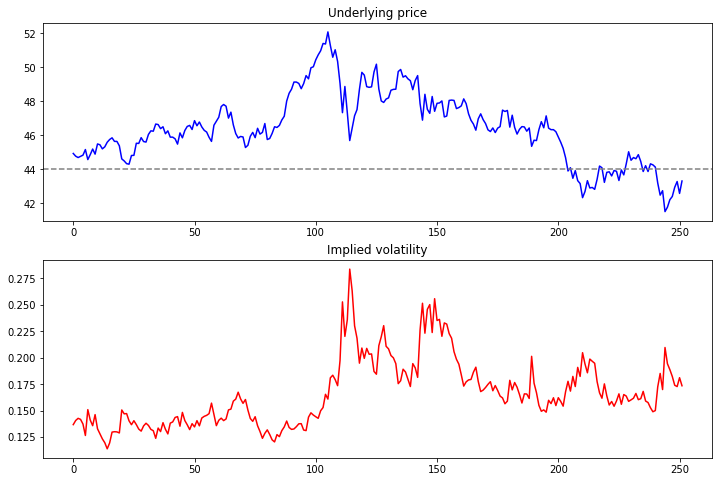

ERROR:ib_insync.client:Peer closed connection


In [9]:
plt.figure(figsize=(12, 8))

data1 = pdo(opt.asset_historic('EEM'))['bar_close']
data2 = pdo(opt.asset_historic_IV('EEM'))['bar_close']

plt.subplot(2, 1, 1)
plt.plot(data1, color = 'blue')
plt.title('Underlying price')
plt.axhline(44, color='gray', linestyle='dashed')

plt.subplot(2, 1, 2)
plt.plot(data2, color = 'red')
plt.title('Implied volatility')

plt.show